# COGS 118B - Final Project

# Names

- Abdul Ibrahim
- Kai Stern
- Patrick Helcl

# Abstract 

This study has the goal of utilizing methods learned in COGS 118B to better cluster company stocks by their volatilities using Gaussian Mixture Models (GMM). We will then later predict future volatility using a Recurrent Neural Network (RNN). This gives us the opportunity to potentially identify more complex patterns that are unseen with use of simpler methods and features. We plan to use unsupervised clustering methods to analyze differences in performance between high and low volatility stocks. We will then use supervised machine learning, via a neural network, to predict future stock volatility given past data for each company. 

We hope this project will present new insights to investment information gained by analyzing how the stocks are clustered together as well as identifying patterns that point towards growth. Success for the unsupervised learning portion of this project will be measured by comparing the silhouette score of a GMM to our baseline k-means model, commonly used in surrounding literature in this field. Additionally, any insights gained from this comparison and determining how useful the measure of volatility is when classifying stocks, will also be considered measurable achievements of or work.


# Background

Stock choice and market prediction have been growing applications of machine learning (ML) over the last several decades. Recognizing and understanding patterns is crucial for both research and successful trading in a system as dynamic and complex as the stock market. Supervised learning approaches to stock market ML analysis typically require deep domain knowledge and extensive human contribution to perform feature engineering <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). Automating this process frees up researchers to focus on other aspects of the problem and enables a lower domain knowledge threshold. Thus, there has been increasing interest in the use of unsupervised algorithms for financial ML purposes. Unsupervised clustering algorithms can help uncover unexpected structure within unlabelled data to suggest areas of research or give a competitive advantage for traders <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). Principal components analysis (PCA) can help to group data based on the characteristics that contribute most to its variability <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Most research on the use of unsupervised learning for financial data is focused on the k-means clustering algorithm which has been found to be a good indicator of high and low volatility conditions across asset classes <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2). Multiple papers cited k-means’ poorer performance on messy data without spherical clusters as a limitation of the algorithm that could be overcome in future research by applying mixture models <a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2) <a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3) Other potential areas of research to avoid human feature engineering include self supervised learning so that algorithms can learn patterns from raw data themselves <a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1). We plan to build upon the literature by implementing a Gaussian Mixture Model clustering that is more generalizable and unique relative to other studies, many of which use a k-means based approach in their research. 


# Problem Statement

After conducting background research on our topic of interest, we identified that the vast majority of machine learning literature frequently uses k-means clustering (a simple algorithm which assumes spherical/circular covariance) when conducting studies on stock data. Our group seeks to understand how clustering and pattern recognition will change when using a more robust and flexible algorithm. Gaussian mixture models are our current algorithm of choice as they can assume a wider array of covariance shape when conducting machine learning research on stock data. This enables us to cluster based on more irregular or less easily separable data. We hope to uncover new insights and better pattern recognition in our research. We will apply what we have learned from the clusterings to make volatility predictions that could enable investors to decide whether to put money into high or low volatility stocks. We chose an RNN for this task as RNNs specialize in looking at sequenced data and predicting future elements based on learned patterns. Our goal from this endeavor is to see if using different techniques compared to current literature can bring new insights to light.

# Data

### Dataset 1 - Stock data from Yahoo Finance

Link to dataset 1 here: https://www.kaggle.com/datasets/iveeaten3223times/massive-yahoo-finance-dataset

Size: 9 Variables, 603K observations 

##### Features of each observation: 

- Date: The date corresponding to the recorded stock market data.
- Open: The opening price of the stock on a given date.
- High: The highest price of the stock reached during the trading day.
- Low: The lowest price of the stock observed during the trading day.
- Close: The closing price of the stock on a specific date.
- Volume: The volume of shares traded on the given date.
- Dividends: Any dividend payments made by the company on that date (if applicable).
- Stock Splits: Information regarding any stock splits occurring on that date.
- Company: Ticker symbol or identifier representing the respective company.

##### Critical values for this dataset

The critical values for this data set are Company, Date, Open, Close. These are important because they will all be used to calculate volatilities for each company and passed into our various ML models for analysis. 

##### Summary of cleaning:

Since our data set has few features and is from Kaggle the values in our data are already very clean. However our group did find that the date values were stored as strings and were in-conveniently stored as the date and the time in a single string. To make this feature more useable we wrote a helper function to clean the string into just the date and convert it into datetime object, supported by pandas, for easier use later in the project with the date attributes and since knowing the exact times of the stock each day would not be necessary due to the timescale of our project.

##### Why this data is important for our project?:

This data is important for our project because it uses a fair amount of different companies and data over time without being so large that our analysis gets too computationally complex. It is a very good data set for conducting financial stock data analysis from a reputable company, Yahoo finance. 

In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from torch import nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


df1 = pd.read_csv('data/stock_details_5_years.csv', header=0)

def time_fixer(x):
    x = x.split(' ')[0]
    return x

df1['Date'] = df1['Date'].apply(time_fixer)
df1['Date'] = pd.to_datetime(df1['Date'])

df1.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


### Data 2 Volatility Data For Each Company (Computed and wrangled from dataset 1)


Dataframe created from the first data set. We are creating a data frame from a subset of the data so that we can group the different stocks by their volatility and run our unsupervised learning / GMM on the open and close data and leverage these features in the most informative way. We included this as a separate section in this data section because this data set is what the ML models use primarily and the first data set comes in later to check different features. Since the data sets are used at different times and are not interchangeable we felt including this in a different section was best. 

In [27]:
#todo - add comments explaining code later
company_opens = df1.groupby('Company')['Open'].apply(np.array)
company_closes = df1.groupby('Company')['Close'].apply(np.array)

changes_df = pd.DataFrame(index=company_opens.index)
changes_df['opens'] = company_opens
changes_df['closes'] = company_closes

def perc_change(open_ser, close_ser): #helper function
    return abs(((close_ser - open_ser) / open_ser )*100.0)
    
data1 = perc_change(changes_df['opens'], changes_df['closes'] )
changes_df['perc_change'] = data1

full_length = changes_df['perc_change'].apply(len).max()
full_companies = changes_df['perc_change'].apply(len)

useable_companies = full_companies[full_companies == full_length]

final_df = changes_df.loc[useable_companies.index]

final_df = final_df.drop(columns=['opens', 'closes'])
final_df.head(10)

,perc_change
Company,
A,"[0.4773218052326546, 1.0051671761984158, 1.827..."
AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951..."
ABBV,"[1.011124035815082, 4.442714837058878, 0.69974..."
ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689..."
ABT,"[1.1459365284516383, 0.1623194184859994, 0.026..."
ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11..."
ACN,"[0.702792270799572, 1.6999443205598022, 0.5121..."
ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090..."
ADI,"[0.5112321590414718, 2.4749178330342025, 0.182..."


# Proposed Solution

After doing research on current literature in financial analysis using machine learning for the stock market, our group found that there was an overabundance of k-means in studies. This overuse of k-means for clustering analysis and model selection was even addressed as a marker for the need of further research in the subject by<a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3). Our group seeks to expand to the current literature by using a Gaussian mixture model (GMM) for clustering of different attributes in the dataset, which can assume covariances other than spherical/circular unlike k-means which have fixed covariance assumptions. We aim to find new and/or more accurate clusterings and patterns than in previous research which could lead to more accurate analysis of stock performance

To determine if the GMM performs better than k-means, our group will also implement a k-means model trained on our data as a benchmark comparison for our findings and metrics. Our group plans to use k-folds cross validation for hyperparameter tuning to ensure the best versions of each model are being compared. Our methodology should be highly reproducible especially if the same years of stock market data are used. Regardless of whether or not better performances are achieved by our model compared to the k-means model, our project will shed light on ML based stock market analysis literature. This will be achieved by showing that our GMM out performed k-means inviting further research into the use of GMM in the space or alternately ruling out the use of GMM’s in further research and supporting the classic k-means and suggesting research into other models beyond the two are needed. 

After comparing the clustering methods we will make use of the information gained by implementing the RNN to make temporal based predictions using our stock data. RNNs are a type of neural network architecture designed to handle sequential data, making them particularly useful for time-series analysis tasks such as stock price prediction.This works for our project as it enables us to look at how a stock behaves over a certain time period then predict how it will behave on a future date. We are using a Long Short-Term Memory (LSTM) RNN which enables it to learn patterns in longer sequences than traditional RNNs as LSTMs include memory cells which maintain information over long periods of time and selectively update or forget information as needed. We give the RNN 30 days of data on the daily percent change in stock value for each company then have it predict what the percent change in value for the stock will be the next day. We then compare the prediction with ground truth. Our solution combines the fields of supervised and unsupervised learning to further the literature on stock related research and build useful tools for predicting stock behavior. 

# Evaluation Metrics

We plan on using a Silhouette score to evaluate our clusterings. This metric measures how well separated and dense clusters are by returning a value between -1 and 1. Negative values suggest data points have been placed in the wrong clusters as data points are closer to points in other clusters. Values near 0 suggest highly overlapping clusters. Values near 1 suggest well separated clusters and dense clusters indicating a ‘better’ Silhouette score. Silhouette scores can break down if clusters are highly irregular. If that ends up being the case with our data we will supplement how we evaluate our models with other evaluation metrics such as adjusted rand score. Comparing the silhouette score of each model will be a good measure of how well our GMM is performing relative to the k-means model, also giving our group an idea of how well our model stacks up to the models used in our background research articles. We will use Mean Absolute Error (MAE) to evaluate the performance of the RNN. MAE evaluates the absolute value of the difference between predicted and true values. MAE is more robust than metrics like Mean Squared Error as using absolute value instead of squaring error distances reduces the impact of outliers. Using MAE as our evaluation metric enables a clear picture of how much error there is in model predictions. 


# Exploratory Data analysis: 

Exploratory Data analysis (EDA) is a common technique used in the early stages of a data science project. The goal of conducting an EDA is to quickly gain an understanding of relationships and structure of the data, typically by visualizing it. In this project we conducted an EDA on principal component analysis, further explained below.


## Principal Component Analysis (PCA)

In any project with dense or large datasets, the use of Principal Component Analysis is necessary. This is especially true for our stock market analysis with the complexity and high dimensionality of our dataset, where each observation (of a company stock) spanned into thousands of individual observations for that stock. The motivation for incorporating PCA was to overcome this incredibly complex dataset. Additionally, PCA is particularly beneficial for GMM’s which are computationally intensive and affected by the curse of dimensionality. 

During our exploratory data analysis stage, we added a PCA section since each data point was described by approximately 1250 data points in each array for each company within our dataset. This was necessary in order to condense the data’s dimensionality without compromising the integrity of our data. To determine the optimal number of PCA components, we employed the elbow method which is shown in our plots in the EDA section that depict a roughly log x or sqrt x shaped blue line curve. Analyzing the plot, we found that 250 components would be a strong number as it explained about 95% of the variance in our dataset. Beyond 250, the plot showed that additional components would produce minimal gains, defeating the purpose of our dimensionality reduction.

During this process, we discovered a data cleaning issue that needed to be addressed: not all companies had the same number of observations. More specifically, not every company had the same 1250 days of data that would allow for uniform analysis. To resolve this issue, we identified and retained only the data points, or companies, that did have 1250 observations. Companies that did not meet this requirement were excluded from our analysis in order to maintain consistency, which is crucial for applying PCA.


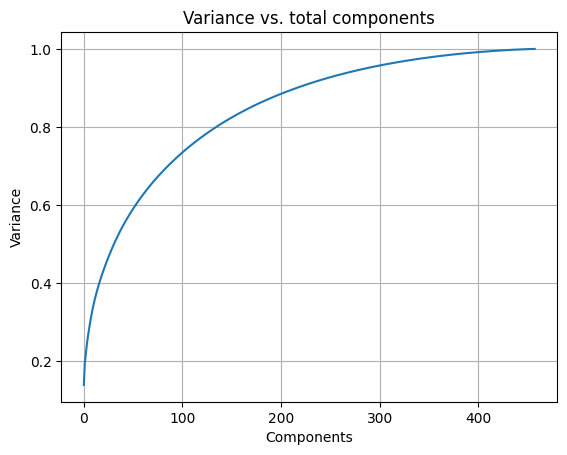

In [28]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA()
pca.fit(X)

# elbow method shown here
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Variance vs. total components')
plt.grid(True)
plt.show()

# best 250

# Results

In the following subsection we will conduct clustering of our data, cross validation for hyper parameter tuning, analysis of different final clusters and supervised learning analysis. Each of these components serve as an integral part to our findings of the project and will be thoroughly explained in sections of writing when appropriate. 

## Subsection 1 - Creating Baseline GMM and K-means Models

To first understand how the GMM and K-means models compare on our data set we implemented both on our PCA data. We started by using 11 clusters as our hyperparameter selection because there are 11 different industries represented in the S&P 500 and we were curious to see if any industry patterns would appear by doing so. To establish a baseline we assessed the performance on the models, we first ran them on PCA processed data without hyper parameter tuning. We also included graphs and then printed out the silhouette scores of each model to gain an understanding of how the models are performing on and clustering the data.


silhouette score: 0.01668696402025226


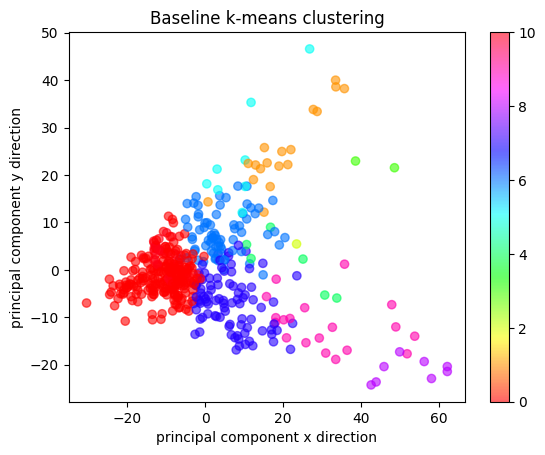

In [29]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA(n_components=250) 
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=11, random_state=24) # use of 11 explained in writing above
cluster_labels = kmeans.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline k-means clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()


silhouette score: 0.03405223881421335


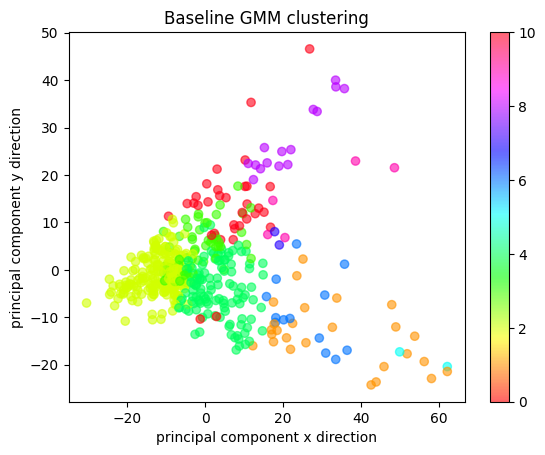

In [30]:
gmm = GaussianMixture(n_components=11, random_state=24)  
cluster_labels = gmm.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline GMM clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

### Subsection 2 - Cross validation and optimization of GMM and K-means base line models

To optimize our GMM and K-means model for clustering the stocks, we applied cross-validation to determine the optimal number of clusters. Cross-validation ensured our model’s robustness by testing it on various data segments and providing a score to assess its performance. Additionally, allowing us to identify the optimal number of clusters that would maximize coherence and distinction among each cluster, which we are able to judge with our silhouette score.  We hypothesized that the GMM model would outperform K-means in clustering of stock data, given GMM’s effectiveness with complex, non spherical data. 

best # of clusters: 2
Corresponding best cross validation silhouette score 0.22577967529605414


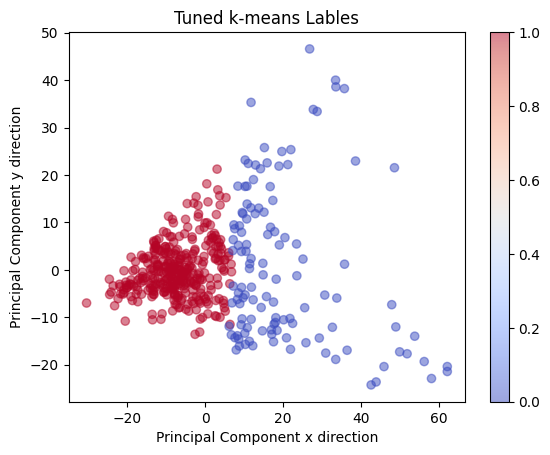

Silhouette score for graphed clustered: 0.2250149421569301


In [31]:
silhouette_scores = []

# corss validation here, note it is unseeded
for n_clusters in range(2, 19):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores += [silh_score]

final_cluster_num = np.argmax(silhouette_scores) + 2 # add 2 because corresponding index is left shifted

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

#kmeans used new found best k param
kmeans = KMeans(n_clusters=final_cluster_num, random_state=24)
cluster_labels = kmeans.fit_predict(X_pca)

#saving labl results for later analysis in finl-df
final_df['k-means label'] = cluster_labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned k-means Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

# silhoutte score from graphed kmeans clustering
final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

best # of clusters: 2
Corresponding best cross validation silhouette score 0.2516260729252442


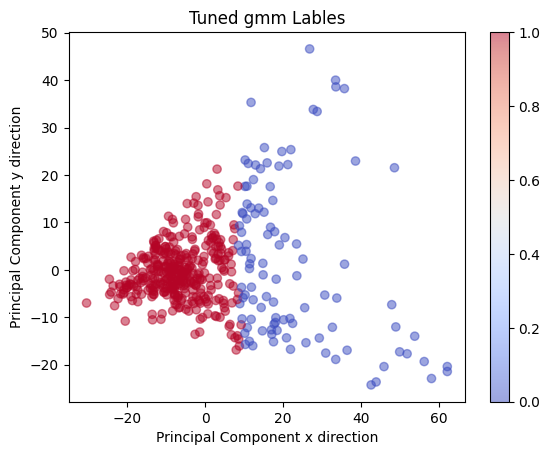

Silhouette score for graphed clustered: 0.2516260729252442


In [47]:
silhouette_scores = []

# cross validation here, note this part is unseeded
for n_components in range(2, 19):
    gmm = GaussianMixture(n_components=n_components)
    cluster_labels = gmm.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silh_score)

final_cluster_num = np.argmax(silhouette_scores) + 2

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

gmm = GaussianMixture(n_components=final_cluster_num, random_state=24)
cluster_labels = gmm.fit_predict(X_pca)

# Update final_df with cluster labels
final_df['gmm labels'] = cluster_labels

# Plot the clustering labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned gmm Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

### Subsection 3 - comparison of clusters from each model

After tuning the different models, both the GMM and K-means models repeatedly selected 2 clusters in the cross validation. Now that we have the labels/groups assigned to each company from both models, we can perform a performance analysis to learn how these clusters and models differ from each other.

##### Preview of Labels From Each Model in Dataframe


In [48]:
# peak at data frame after adding labels from our models
final_df.head(8)

,perc_change,k-means label,gmm labels,avg_volatility,avg last 90
Company,,,,,
A,"[0.4773218052326546, 1.0051671761984158, 1.827...",1,1,1.101325,1.139640
AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951...",1,1,1.162724,0.861862
ABBV,"[1.011124035815082, 4.442714837058878, 0.69974...",1,1,0.946333,0.643882
ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689...",1,1,1.378099,1.012984
ABT,"[1.1459365284516383, 0.1623194184859994, 0.026...",1,1,0.997566,0.873281
ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11...",1,1,1.224913,1.137017
ACN,"[0.702792270799572, 1.6999443205598022, 0.5121...",1,1,0.973349,0.709836
ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090...",0,1,1.335225,1.240969


##### Comparing Volatility of Clusters in K-means Model

We can see that in the k-means model cluster 0 also has a higher average volatility than cluster one. We typically found cluster 0’s volatility measure to be about ~0.70 higher than label 0 depending on the re-rerun of the code. Here volatility is measured as the average absolute percentage change of a stock prices for all companies included in each cluster.

In [49]:
final_df['avg_volatility'] = final_df['perc_change'].apply(lambda x: x.mean())
final_df[['k-means label', 'avg_volatility']].groupby('k-means label').mean()

,avg_volatility
k-means label,
0,1.698008
1,1.049724


##### Comparing Volatility of Clusters in GMM model

We can see that in the GMM cluster 0 also has a higher average volatility than cluster one. We typically found cluster 0’s volatility measure to be about ~0.75 higher than label 0 depending on the re-rerun of the code..

In [50]:
final_df[['gmm labels', 'avg_volatility']].groupby('gmm labels').mean()

,avg_volatility
gmm labels,
0,1.750199
1,1.065626


##### Extracting company names from each cluster and showing size of clusters 

In [36]:
kmeans_0 = final_df.index[final_df['k-means label'] == 0].values

kmeans_1 = final_df.index[final_df['k-means label'] == 1].values

gmm_0 = final_df.index[final_df['gmm labels'] == 0].values

gmm_1 = final_df.index[final_df['gmm labels'] == 1].values

#lengths of each 

print("k-means 0 length:", len(kmeans_0))
print("k-means 1 length:", len(kmeans_1), '\n')
print("gmm 0 length:", len(gmm_0))
print("gmm 1 length:", len(gmm_1), '\n')

# to visualize what these arrays look like here is a snippet of first 10 companies in the 1-label groups
print(gmm_1[0:10])
print(kmeans_1[0:10])


k-means 0 length: 120
k-means 1 length: 338 

gmm 0 length: 65
gmm 1 length: 23 

['ALNY' 'AMD' 'BGNE' 'CCJ' 'CCL' 'DXCM' 'HUBS' 'MDB' 'MELI' 'PCG']
['A' 'AAPL' 'ABBV' 'ABEV' 'ABT' 'ACGL' 'ACN' 'ADI' 'ADM' 'ADP']


#### Finding Average Close Price for each company over last 3 months in data set

In [51]:
last_quart_cutoff = df1['Date'].max() - timedelta(days=90)  #90 for 3 months (1 financial quarter)

final_quarter_only = df1[df1['Date'] >= last_quart_cutoff]

final_quarter_avgs = final_quarter_only.groupby('Company').mean()

final_quarter_avgs  = final_quarter_avgs.drop(columns=['Open', 'High', 'Low', 'Volume', "Dividends", 'Stock Splits'])
final_quarter_avgs

,Close
Company,
A,112.198726
AAPL,178.937359
ABBV,145.091578
ABEV,2.644470
ABNB,128.831905
...,...
YUM,123.770971
ZBH,111.488542
ZM,65.788254


#### Creating Boxplots to show performance of clusters

Due to the large size of each cluster as a result of using only 2 clusters per model, our group felt that a simple metric such as using the mean was an unfair and inaccurate way to compare the average closing prices and growth for all clusters. To solve this problem we decided to implement a boxplot for each cluster and compare the median and different quartiles of each cluster to get a more accurate representation of cluster differences. This is especially useful because the mean is susceptible to outliers and having so many points in each cluster makes it extremely likely that metrics will be biased and inaccurate from these outliers. Therefore by utilizing the median and quartiles which are much more robust to outliers we are able to conduct a less biased comparison between the clusters. 

##### K-means section:

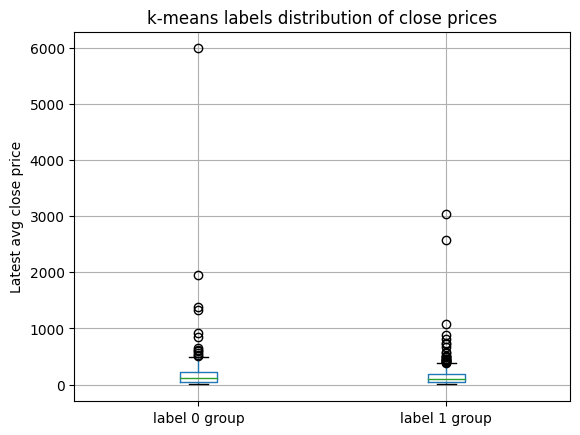

Median label 0 Median: 112.5698233104887
Lower quartile label 0: 52.37449794345432
Upper quartile label 0: 229.39011334616043 

Median for label 1 group: 93.44891387697251
Lower quartile label 1: 46.27500048137846
Upper quartile label 1: 181.35955695500456


In [38]:
#kmeans
kmean_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_0)]
kmean_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_1)]

fig, ax = plt.subplots()

box1 = kmean_0_avgs.boxplot(column='Close',  positions=[1])
box2 = kmean_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('k-means labels distribution of close prices')

plt.show()

# after creating code for plot we use code below to print the actual values this is due to ranges being so different

kmeans0_median = kmean_0_avgs['Close'].median()
kmeans0_lower_q = kmean_0_avgs['Close'].quantile(0.25)
kmeans0_upper_q = kmean_0_avgs['Close'].quantile(0.75)

kmeans1_median = kmean_1_avgs['Close'].median()
kmeans1_lower_q = kmean_1_avgs['Close'].quantile(0.25)
kmeans1_upper_q = kmean_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", kmeans0_median)
print("Lower quartile label 0:", kmeans0_lower_q)
print("Upper quartile label 0:", kmeans0_upper_q, '\n')

print("Median for label 1 group:", kmeans1_median)
print("Lower quartile label 1:", kmeans1_lower_q)
print("Upper quartile label 1:", kmeans1_upper_q)

plt.show()


### GMM Section

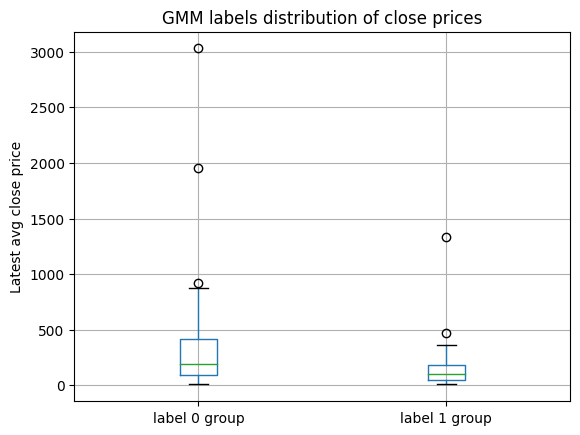

Median label 0 Median: 194.38923427036832
Lower quartile label 0: 91.20233989897228
Upper quartile label 0: 414.70714121016243 

Median for label 1 group: 105.38999987405447
Lower quartile label 1: 45.30936510600742
Upper quartile label 1: 179.6450002761115


In [39]:
#gmm
gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

fig, ax = plt.subplots()

box1 = gmm_0_avgs.boxplot(column='Close',  positions=[1])
box2 = gmm_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('GMM labels distribution of close prices')

plt.show()

gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

gmm0_median = gmm_0_avgs['Close'].median()
gmm0_lower_q = gmm_0_avgs['Close'].quantile(0.25)
gmm0_upper_q = gmm_0_avgs['Close'].quantile(0.75)

gmm1_median = gmm_1_avgs['Close'].median()
gmm1_lower_q = gmm_1_avgs['Close'].quantile(0.25)
gmm1_upper_q = gmm_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", gmm0_median)
print("Lower quartile label 0:", gmm0_lower_q)
print("Upper quartile label 0:", gmm0_upper_q, '\n')

print("Median for label 1 group:", gmm1_median)
print("Lower quartile label 1:", gmm1_lower_q)
print("Upper quartile label 1:", gmm1_upper_q)


### Analysis of growth section

As previously explained we use the same principles of using median and quartiles to compare the performance of different clusters without the results being as susceptible to outliers. However in this section instead of comparing the average close prices we compare the average growth percentage of the different clusters. 


In [54]:
#calculating grow for companies
def get_last3_month(array):
    
    return sum(array[-90:]) / 90.0

final_df['avg last 90']= final_df['perc_change'].apply(get_last3_month)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]

#preview of data used:

kmean_0_changes[:5]

,avg last 90
Company,
ADBE,1.240969
ADSK,1.175654
AEM,1.130475
ALNY,1.251380
AMAT,1.319051


### K-means Growth Section

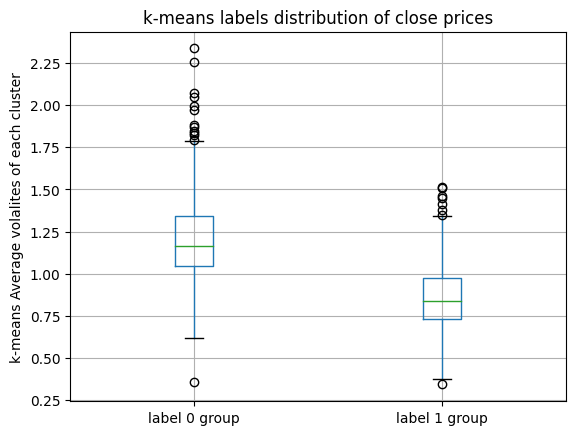

In [55]:
#calculating grow for companies
def get_last3_month(array):
    
    return sum(array[-90:]) / 90.0

final_df['avg last 90']= final_df['perc_change'].apply(get_last3_month)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]


fig, ax = plt.subplots()

final_box1 = kmean_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = kmean_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('k-means Average volalites of each cluster')
ax.set_title('k-means labels distribution of close prices')

plt.show()

### GMM Growth Section

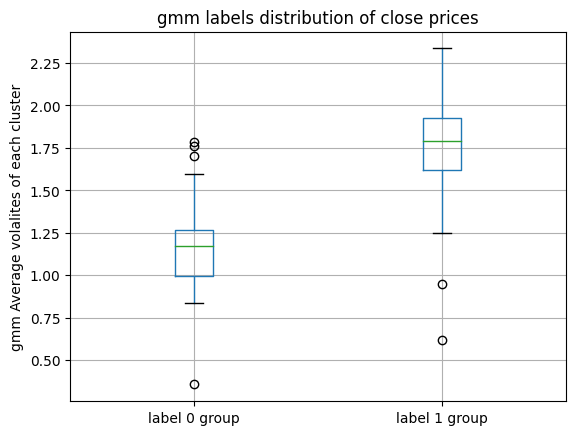

In [56]:
gmm_0_changes = final_90_changes[final_90_changes.index.isin(gmm_0)]
gmm_1_changes = final_90_changes[final_90_changes.index.isin(gmm_1)]


fig, ax = plt.subplots()

final_box1 = gmm_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = gmm_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('gmm Average volalites of each cluster')
ax.set_title('gmm labels distribution of close prices')

plt.show()

### Subsection 4 - Recurrent Neural Network for Volatility Prediction

Now that we have shown that there is value in knowing the volatility of the stock we decided to use an RNN to predict volatility in the same dataset as our clustering analysis. This requires data wrangling, initializing the model architecture, training the model, testing the model, and evaluating its success. 

#### Data Wrangling and Prep for Neural Network 

The RNN required slightly different data input than the GMM and K-means models. Thus, we separated out the ‘perc_change’ column which represents the stock volatility into its own list. We then looped through this list to select the 30 day chunks of data for each company for training. From there we split the data into train and test sets and converted the lists to pytorch tensors to maximize model efficiency.  

In [58]:
data = final_df['perc_change'].tolist()
sequence_length = 30  

X = []
y = []

for stock_data in data:
    last_31_days = stock_data[-31:]
    if len(last_31_days) == 31:
        X.append(last_31_days[:-1])
        y.append(last_31_days[1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], sequence_length, 1)
X_test = X_test.reshape(X_test.shape[0], sequence_length, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Initialize Model

After setting up our data we initialized the layers of the model and set up its forward pass. We initialize the size of the input, hidden layer, number of recurrent layers, and output. We use both LSTM and Linear layers. The forward initializes the hidden and cell states h0 and c0 as tensors filled with zeros then moves onto the recurrent and output layers.

In [42]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


### Training

Once we finished setting up the model architecture we trained the model on the training tensors initialized above. We iterated through 10 epochs and can see that the process worked well as training error decreased with each iteration. Test error was slightly higher than training error which is to be expected.

In [43]:
model = StockRNN(input_size=1, hidden_size=50, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    y_pred = model(X_test_tensor).squeeze().numpy()
    test_loss = criterion(torch.tensor(y_pred), y_test_tensor.unsqueeze(1)).item()
    print(f'Test Loss: {test_loss:.4f}')

Epoch [1/10], Loss: 2.1596
Epoch [2/10], Loss: 2.1085
Epoch [3/10], Loss: 2.0575
Epoch [4/10], Loss: 2.0060
Epoch [5/10], Loss: 1.9539
Epoch [6/10], Loss: 1.9006
Epoch [7/10], Loss: 1.8458
Epoch [8/10], Loss: 1.7888
Epoch [9/10], Loss: 1.7292
Epoch [10/10], Loss: 1.6659
Test Loss: 2.6551


/Users/patrick/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([92, 1])) that is different to the input size (torch.Size([92])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Testing 

For the final step of the modeling process we used the trained RNN to make predictions on the volatility of each company in the dataset. We compared these predictions to the actual values using mae. The MAE value was 0.767 which is relatively low in the context of this problem. 

In [44]:
actual_values = []
predicted_values = []

for i, stock_data in enumerate(data):
    actual_value = stock_data[-1]
    actual_values.append(actual_value)

    X_tensor = torch.tensor(stock_data[-31:], dtype=torch.float32).unsqueeze(0).unsqueeze(2)  

    model = StockRNN(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    with torch.no_grad():
        model.eval()
        prediction = model(X_tensor).item()
    predicted_values.append(prediction)


actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)

print("mean absolute Error:", mae)
print("mean squared Error:", mse)

mean absolute Error: 0.7609698659018577
mean squared Error: 1.4024082106991642


### Comparing to Ground Truth

In [45]:
Compare = pd.DataFrame({'Pred': predicted_values, 'Actual': actual_values})
Compare

,Pred,Actual
0,0.054804,1.130668
1,0.008838,0.531692
2,0.066139,0.496303
3,-0.064930,0.666665
4,-0.079117,0.827504
...,...,...
453,-0.043525,0.319151
454,-0.090412,0.696479
455,-0.171423,0.872245
456,-0.041415,3.076997


### Graphing Performance

Graphing our RNN’s predictions, in blue, against the actual values, in orange,  shows that our model makes fairly conservative predictions. The blue line hovers around zero while the orange line makes higher amplitude curves to either direction.

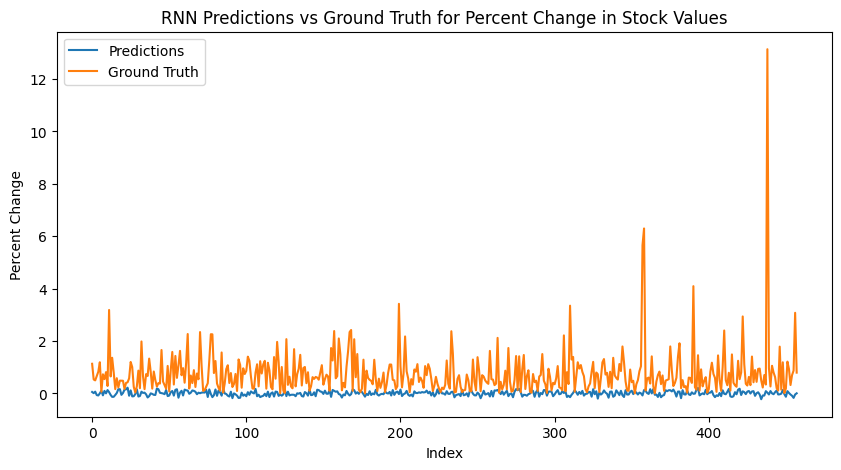

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(Compare['Pred'], label='Predictions')
plt.plot(Compare['Actual'], label='Ground Truth')
plt.title('RNN Predictions vs Ground Truth for Percent Change in Stock Values')
plt.xlabel('Index')
plt.ylabel('Percent Change')
plt.legend()
plt.show()

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   



### Ethics & Privacy

In regards to ethics and privacy our group’s project does not have any major ethical or privacy related concerns. Our project is built on data from publicly traded stocks of companies, which as the name implies are freely available to the public to access. 

Additionally, our data set does not contain any information about individuals since all data pertains to different companies, meaning we do not have to account for or worry about precautions such as personally identifiable data or major biases in data (e.g. political or socio economic). Additional benefits of using publicly available data on business and corporations instead of data from human beings include no need for informed consent, confidentiality and/or anonymity of participants. 

Since the data being used is from Kaggle, one potential issue with our data is the potential for altered or fabricated data about the different stocks and companies during scraping from the original poster. Some examples of this would include: errors in the data aggregation process or code that would store incorrect data, neglect of certain time periods or companies for sake of efficiency or information size, and personal bias from the data curator to select companies from yahoo finance based on some reason undisclosed on Kaggle (therefore unavailable for our group to identify). If any issues with the data are identified at any point in this project our group will take the necessary steps and precautions to identify, eliminate, or correct these issues and concerns.

Another potential concern as a result of the project is potential for our findings to influence stock investors which could theoretically have effects on the trading volume of different stocks or stocks with certain attributes identified with our models. In this scenario, the company's stock price would either be increased or decreased from our findings. However, it is worth noting that with our group member’s background and no previous experience in analyzing financial data we find this scenario to be extremely unlikely since our project should be viewed as a non reputable source and not comparable to suggestions from professional financial organizations. That being said, it is our group’s responsibility to identify any possible concerns and risks of the project no matter how likely. 

Overall this project has very few concerns and issues which also happen to be very unlikely after all things considered, thus this project should be free of any major confounds and issues that would make the accuracy and applicability of our findings questionable.



### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes

1. <a name="cite_note-1"></a> [^](#cite_ref-1) Ying, Z. et al. (1 Feb 2024) Predicting stock market trends with self-supervised learning and extreme value theory. *Neurocomputing*. https://www.sciencedirect.com/science/article/abs/pii/S0925231223011566

2. <a name="cite_note-2"></a> [^](#cite_ref-2) Barradas, A., et al. (July, 2023) Identification of Patterns in the Stock Market through Unsupervised Algorithms. *MDPI*. https://www.mdpi.com/2813-2203/2/3/33

3. <a name="cite_note-3"></a> [^](#cite_ref-3) Lee, J. (1 Sep 2016) Clustering Approaches for Financial Data Analysis: a Survey. *School of Computer Science Science & Informatics, University College Dublin, Ireland*. https://arxiv.org/abs/1609.08520
